# Twitter Sentiment Analysis Part 1
## Acquiring the data with Spark Structured Streaming

In [38]:
# uncomment and run the line below to install tweepy if needed
# !pip install tweepy

## Set up twitter authentication
Make sure to fill in the tokens below before running this cell

In [3]:
from tweepy import OAuthHandler

# Go to http://apps.twitter.com and create an app.
# The consumer key and secret will be generated for you after
consumer_key="XXXXX"
consumer_secret="XXXXX"

# After the step above, you will be redirected to your app's page.
# Create an access token under the the "Your access token" section
access_token="XXXXX"
access_token_secret="XXXXX"

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

## Create the Twitter Stream

In [4]:
from tweepy.streaming import StreamListener
from tweepy import Stream
from six import iteritems
import json
import csv
import shutil
from bs4 import BeautifulSoup as BS
from pyspark.sql.types import StructType, StructField, StringType, DateType

def ensure_dir(dir, delete_tree = False):
    if not os.path.exists(dir):
        os.makedirs(dir)
    elif delete_tree:
        shutil.rmtree(dir)
        os.makedirs(dir)
    return os.path.abspath(dir)

root_dir = ensure_dir("output", delete_tree = True)
output_dir = ensure_dir(os.path.join(root_dir, "raw"))
field_metadata = [
    {"name": "created_at","type": DateType()},
    {"name": "text", "type": StringType()},
    {"name": "source", "type": StringType(), 
         "transform": lambda s: BS(s, "html.parser").text.strip()
    }
]
fieldnames = [f["name"] for f in field_metadata]
transforms = { 
    item['name']:item['transform'] for item in field_metadata if "transform" in item
}

class RawTweetsListener(StreamListener):
    def __init__(self):
        self.buffered_data = []
        self.counter = 0

    def flush_buffer_if_needed(self):
        "Check the buffer capacity and write to a new file if needed"
        length = len(self.buffered_data)
        if length > 0 and length % 10 == 0:
            with open(os.path.join( output_dir, "tweets{}.csv".format(self.counter)), "w") as fs:
                self.counter += 1
                csv_writer = csv.DictWriter( fs, fieldnames = fieldnames)
                for data in self.buffered_data:
                    csv_writer.writerow(data)
            self.buffered_data = []

    def on_data(self, data):
        def transform(key, value):
            return transforms[key](value) if key in transforms else value

        self.buffered_data.append(
            {key:transform(key,value) \
                 for key,value in iteritems(json.loads(data)) \
                 if key in fieldnames}
        )
        self.flush_buffer_if_needed()
        return True

    def on_error(self, status):
        print("An error occured while receiving streaming data: {}".format(status))
        return False

In [5]:
def start_stream(queries):
    "Asynchronously start a new Twitter stream"
    stream = Stream(auth, RawTweetsListener())
    stream.filter(track=queries, async=True)
    return stream

## Start a new Twitter stream filtered by the keyword "baseball"

In [6]:
stream = start_stream(["baseball"])

In [39]:
# uncomment this line to stop the twitter stream
#stream.disconnect()

## Create a Spark Streaming DataFrame

In [10]:
schema = StructType(
    [StructField(f["name"], f["type"], True) for f in field_metadata]
)
csv_sdf = spark.readStream \
    .csv(
        output_dir,
        schema=schema,
        multiLine = True,
        dateFormat = 'EEE MMM dd kk:mm:ss Z y',
        ignoreTrailingWhiteSpace = True,
        ignoreLeadingWhiteSpace = True
    )
csv_sdf.isStreaming

True

In [11]:
csv_sdf.printSchema()

root
 |-- created_at: date (nullable = true)
 |-- text: string (nullable = true)
 |-- source: string (nullable = true)



## Create an Run Spark Structured Queries
1. Print to console for debugging
2. Write to parquet database

In [12]:
console_streaming_query = csv_sdf.writeStream\
  .outputMode("append")\
  .format("console")\
  .trigger(processingTime='2 seconds')\
  .start()

In [40]:
# uncomment to stop the structured query
#console_streaming_query.stop()

In [13]:
tweet_streaming_query = csv_sdf \
  .writeStream \
  .format("parquet") \
  .option("path", os.path.join(root_dir, "output_parquet")) \
  .trigger(processingTime="2 seconds") \
  .option("checkpointLocation", os.path.join(root_dir, "output_chkpt")) \
  .start()

In [41]:
# uncomment to stop the structured query
#tweet_streaming_query.stop()

## Monitoring the Streaming Queries

In [25]:
print(spark.streams.active)

[<pyspark.sql.streaming.StreamingQuery object at 0x12d7db6a0>, <pyspark.sql.streaming.StreamingQuery object at 0x12d269c18>]


In [37]:
import json
for query in spark.streams.active:
    print("-----------")
    print("id: {}".format(query.id))
    print(json.dumps(query.lastProgress, indent=2, sort_keys=True))

-----------
id: b621e268-f21d-4eef-b6cd-cb0bc66e53c4
{
  "batchId": 18,
  "durationMs": {
    "getOffset": 4,
    "triggerExecution": 4
  },
  "id": "b621e268-f21d-4eef-b6cd-cb0bc66e53c4",
  "inputRowsPerSecond": 0.0,
  "name": null,
  "numInputRows": 0,
  "processedRowsPerSecond": 0.0,
  "runId": "d2459446-bfad-4648-ae3b-b30c1f21be04",
  "sink": {
    "description": "org.apache.spark.sql.execution.streaming.ConsoleSinkProvider@586d2ad5"
  },
  "sources": [
    {
      "description": "FileStreamSource[file:/Users/dtaieb/cdsdev/notebookdev/Pixiedust/book/Chapter7/output/raw]",
      "endOffset": {
        "logOffset": 17
      },
      "inputRowsPerSecond": 0.0,
      "numInputRows": 0,
      "processedRowsPerSecond": 0.0,
      "startOffset": {
        "logOffset": 17
      }
    }
  ],
  "stateOperators": [],
  "timestamp": "2018-04-12T21:40:10.004Z"
}
-----------
id: 520a8dcc-2acb-4f38-a18d-ef757a20866f
{
  "batchId": 16,
  "durationMs": {
    "getOffset": 4,
    "triggerExecution": 

## Creating a batch DataFrame from the parquet files

In [14]:
parquet_batch_df = spark.sql("select * from parquet.`{}`".format(os.path.join(root_dir, "output_parquet")))

## Display the data using PixieDust


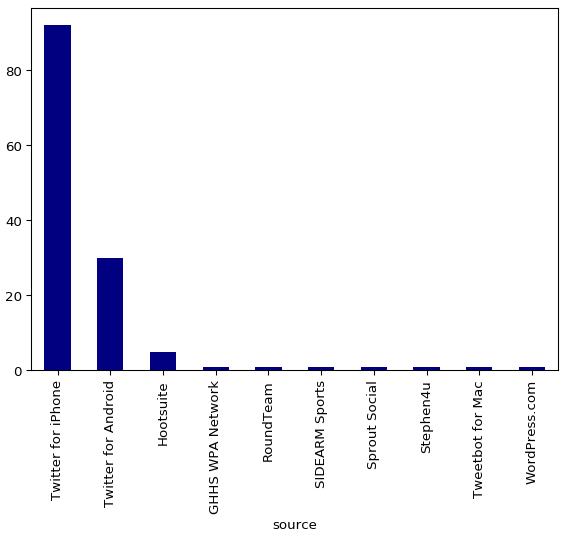

In [19]:
import pixiedust
display(parquet_batch_df)